In [11]:
# import pytorch
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import os
import time
import copy
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np

from torchvision.datasets import ImageFolder

In [3]:
# loading CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Using downloaded and verified file: ./data/cifar-10-python.tar.gz
Files already downloaded and verified


In [4]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
# dataiter = iter(trainloader)
#images, labels = dataiter.next()

# show images
#imshow(torchvision.utils.make_grid(images))
# print labels
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [5]:
from torchvision.datasets import ImageFolder

new_transform = transforms.Compose(
    [transforms.Resize([64, 64]),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [7]:
# get some random training images
new_dataiter = iter(test_data_loader)
new_images, new_labels = new_dataiter.next()

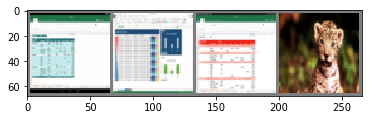

In [8]:
# show images
imshow(torchvision.utils.make_grid(new_images))

In [11]:
# initial network Definition
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 13 * 13, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 13 * 13)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [10]:
# Define loss fucntion and optimizer

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [12]:
# Training process

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(test_data_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Finished Training


In [13]:
running_loss

5.470370292663574

## ==========================
## Transfer Learning
## ==========================

In [71]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

trans_data_dir = './bing_data1/'
trans_image_datasets = {x: ImageFolder(os.path.join(trans_data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
trans_dataloaders = {x: DataLoader(trans_image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
trans_dataset_sizes = {x: len(trans_image_datasets[x]) for x in ['train', 'val']}
trans_class_names = trans_image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

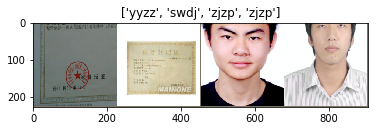

In [72]:
# Showing image preivew for transfer learning datatsets
def trans_imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(trans_dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

trans_imshow(out, title=[trans_class_names[x] for x in classes])

In [73]:
def trans_train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in trans_dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / trans_dataset_sizes[phase]
            epoch_acc = running_corrects.double() / trans_dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Generic function to display predictions for a few images

In [88]:
def visualize_model(loader, model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(trans_class_names[preds[j]]))
                trans_imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Finetuning the convnet
#### Load a pretrained model and reset final fully connected layer.

In [75]:
model_ft = torchvision.models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(trans_class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

#### Train and evaluate

In [76]:
model_ft = trans_train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/Users/elainetuang/tensorflow-env/lib/python3.6/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.5341 Acc: 0.7796
val Loss: 0.4040 Acc: 0.8333

Epoch 1/24
----------


/Users/elainetuang/tensorflow-env/lib/python3.6/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.4308 Acc: 0.8429
val Loss: 0.4069 Acc: 0.8286

Epoch 2/24
----------


/Users/elainetuang/tensorflow-env/lib/python3.6/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.4070 Acc: 0.8581
val Loss: 0.4280 Acc: 0.7952

Epoch 3/24
----------


/Users/elainetuang/tensorflow-env/lib/python3.6/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.3674 Acc: 0.8699
val Loss: 0.4562 Acc: 0.8190

Epoch 4/24
----------


/Users/elainetuang/tensorflow-env/lib/python3.6/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.3387 Acc: 0.8826
val Loss: 0.3436 Acc: 0.8714

Epoch 5/24
----------


/Users/elainetuang/tensorflow-env/lib/python3.6/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.2553 Acc: 0.9088
val Loss: 0.4324 Acc: 0.8190

Epoch 6/24
----------


/Users/elainetuang/tensorflow-env/lib/python3.6/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.2646 Acc: 0.9088
val Loss: 0.3695 Acc: 0.8571

Epoch 7/24
----------


/Users/elainetuang/tensorflow-env/lib/python3.6/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.2371 Acc: 0.9299
val Loss: 0.3402 Acc: 0.8476

Epoch 8/24
----------


/Users/elainetuang/tensorflow-env/lib/python3.6/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.1960 Acc: 0.9375
val Loss: 0.3443 Acc: 0.8857

Epoch 9/24
----------


/Users/elainetuang/tensorflow-env/lib/python3.6/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.1865 Acc: 0.9443
val Loss: 0.3283 Acc: 0.8619

Epoch 10/24
----------


/Users/elainetuang/tensorflow-env/lib/python3.6/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.2343 Acc: 0.9248
val Loss: 0.3222 Acc: 0.8667

Epoch 11/24
----------


/Users/elainetuang/tensorflow-env/lib/python3.6/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.2223 Acc: 0.9341
val Loss: 0.3429 Acc: 0.8667

Epoch 12/24
----------


/Users/elainetuang/tensorflow-env/lib/python3.6/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.2223 Acc: 0.9257
val Loss: 0.3243 Acc: 0.8571

Epoch 13/24
----------


/Users/elainetuang/tensorflow-env/lib/python3.6/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.2105 Acc: 0.9299
val Loss: 0.3385 Acc: 0.8571

Epoch 14/24
----------


/Users/elainetuang/tensorflow-env/lib/python3.6/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.1857 Acc: 0.9358
val Loss: 0.3360 Acc: 0.8571

Epoch 15/24
----------


/Users/elainetuang/tensorflow-env/lib/python3.6/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.2161 Acc: 0.9291
val Loss: 0.3593 Acc: 0.8571

Epoch 16/24
----------


/Users/elainetuang/tensorflow-env/lib/python3.6/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.2225 Acc: 0.9299
val Loss: 0.3311 Acc: 0.8667

Epoch 17/24
----------


/Users/elainetuang/tensorflow-env/lib/python3.6/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.2110 Acc: 0.9324
val Loss: 0.3308 Acc: 0.8524

Epoch 18/24
----------


/Users/elainetuang/tensorflow-env/lib/python3.6/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.2331 Acc: 0.9172
val Loss: 0.3422 Acc: 0.8381

Epoch 19/24
----------


/Users/elainetuang/tensorflow-env/lib/python3.6/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.1758 Acc: 0.9459
val Loss: 0.3172 Acc: 0.8571

Epoch 20/24
----------


/Users/elainetuang/tensorflow-env/lib/python3.6/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.1881 Acc: 0.9350
val Loss: 0.3391 Acc: 0.8619

Epoch 21/24
----------


/Users/elainetuang/tensorflow-env/lib/python3.6/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.1585 Acc: 0.9451
val Loss: 0.3695 Acc: 0.8429

Epoch 22/24
----------


/Users/elainetuang/tensorflow-env/lib/python3.6/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.2120 Acc: 0.9358
val Loss: 0.3312 Acc: 0.8619

Epoch 23/24
----------


/Users/elainetuang/tensorflow-env/lib/python3.6/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.1821 Acc: 0.9358
val Loss: 0.3583 Acc: 0.8429

Epoch 24/24
----------


/Users/elainetuang/tensorflow-env/lib/python3.6/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.2261 Acc: 0.9240
val Loss: 0.3463 Acc: 0.8524

Training complete in 163m 52s
Best val Acc: 0.885714


In [115]:
# Save trainned model

PATH = './trans_resnet_1.pth'
sm = torch.jit.script(model_ft)
sm.save(PATH)
trans_class_names

torch.save(model_ft, './trans_restnet_full_model')

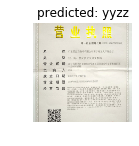

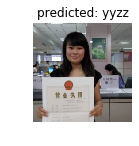

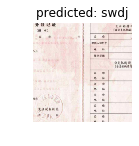

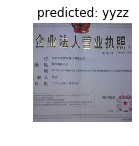

In [89]:
visualize_model(trans_dataloaders['val'], model_ft)

## ===================
## Tensorboard
## ===================

In [82]:
# Tensorboard Setup
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/zz_experiment_2')

In [80]:
# get some random training images
dataiter = iter(trans_dataloaders['train'])
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)


# write to tensorboard
writer.add_image('demo_zz_images', img_grid)
writer.add_graph(model_ft, images)

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x1267ef8d0>>
Traceback (most recent call last):
  File "/Users/elainetuang/tensorflow-env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/Users/elainetuang/tensorflow-env/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
Keyboa

#### Assessing trained models with TensorBoard

In [83]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
# takes ~10 seconds to run
import torch.nn.functional as F

class_probs = []
class_preds = []
with torch.no_grad():
    for data in trans_dataloaders['val']:
        images, labels = data
        output = model_ft(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        _, class_preds_batch = torch.max(output, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(trans_class_names[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(trans_class_names)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)

### ======================
### Testing model performance
### ======================

In [105]:
test_data = ImageFolder(root="./bing/", transform=data_transforms['val'])
test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=4,
                                         shuffle=False, num_workers=2)

In [106]:
# calculate model performance

correct = 0
total = 0
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 92 %


In [113]:
# validate predict results
dataiter = iter(test_data_loader)
iter_images, iter_labels = dataiter.next()
class_names = test_data.classes

for i in range(4):
    output = model_ft(iter_images)
    print(output)
    score, predicted = torch.max(output.data, 1)
    print(score)
    sm = torch.nn.Softmax()
    probabilities = sm(output) 
    print(probabilities) #Converted to probabilities
    print('predicted labels: %s' % class_names[predicted[1]])
    print('actual labels: %s' % class_names[iter_labels[i]])

tensor([[ 1.4996,  6.0112, -8.2059],
        [ 2.2460,  6.5187, -8.3962],
        [ 2.5224,  6.6406, -9.4447],
        [ 2.7638,  6.5955, -9.7944]], grad_fn=<AddmmBackward>)
tensor([6.0112, 6.5187, 6.6406, 6.5955])
tensor([[1.0862e-02, 9.8914e-01, 6.6198e-07],
        [1.3753e-02, 9.8625e-01, 3.2849e-07],
        [1.6014e-02, 9.8399e-01, 1.0168e-07],
        [2.1214e-02, 9.7879e-01, 7.4584e-08]], grad_fn=<SoftmaxBackward>)
predicted labels: yyzz
actual labels: yyzz


/Users/elainetuang/tensorflow-env/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if sys.path[0] == '':


tensor([[ 1.4996,  6.0112, -8.2059],
        [ 2.2460,  6.5187, -8.3962],
        [ 2.5224,  6.6406, -9.4447],
        [ 2.7638,  6.5955, -9.7944]], grad_fn=<AddmmBackward>)
tensor([6.0112, 6.5187, 6.6406, 6.5955])
tensor([[1.0862e-02, 9.8914e-01, 6.6198e-07],
        [1.3753e-02, 9.8625e-01, 3.2849e-07],
        [1.6014e-02, 9.8399e-01, 1.0168e-07],
        [2.1214e-02, 9.7879e-01, 7.4584e-08]], grad_fn=<SoftmaxBackward>)
predicted labels: yyzz
actual labels: yyzz
tensor([[ 1.4996,  6.0112, -8.2059],
        [ 2.2460,  6.5187, -8.3962],
        [ 2.5224,  6.6406, -9.4447],
        [ 2.7638,  6.5955, -9.7944]], grad_fn=<AddmmBackward>)
tensor([6.0112, 6.5187, 6.6406, 6.5955])
tensor([[1.0862e-02, 9.8914e-01, 6.6198e-07],
        [1.3753e-02, 9.8625e-01, 3.2849e-07],
        [1.6014e-02, 9.8399e-01, 1.0168e-07],
        [2.1214e-02, 9.7879e-01, 7.4584e-08]], grad_fn=<SoftmaxBackward>)
predicted labels: yyzz
actual labels: yyzz
tensor([[ 1.4996,  6.0112, -8.2059],
        [ 2.2460,  6.51

In [93]:
print(class_names)

['swdj', 'yyzz', 'zzjp']
